In [75]:
import numpy as np
from helpers import load_data
import scipy.sparse as sp

def read_submission_files(files):
    sparse_matrices = []
    for i,file_ in enumerate(files):
        sparse_matrix = load_data(file_)
        sparse_matrices.append(sparse_matrix.copy())
    return sparse_matrices

def read_numpy_files(files, indices):
    '''
    Read data from numpy files and apply indices to create sparse matrix. 
    '''
    sparse_matrices = []
    for i,file_ in enumerate(files):
        dense_matrix = np.load(file_)
        print('matrix',i)
        print('dense matrix shape:',dense_matrix.shape)
        print('first elements:\n',dense_matrix[:50,:50])
        sparse_matrix = apply_indices_matrix(dense_matrix, indices)
        sparse_matrices.append(sparse_matrix.copy())
        print('number of non-zero elements in matrix:',sparse_matrix.nnz)
    return sparse_matrices

def apply_indices_matrix(matrix, indices):
    '''
    Extract indices from dense or sparse matrix. 
    '''
    sparse_matrix = sp.lil_matrix(matrix.shape)
    sum_nnz = 0
    counter = 0
    for (i,j) in indices:
        counter += 1
        sparse_matrix[i,j] = matrix[i,j] 
        if matrix[i,j] > 0: 
            sum_nnz += 1
    if sum_nnz == 0:
        print("all {} elements zero!".format(counter))
    return sparse_matrix

def apply_indices(sparse_matrices, dataset='train'):
    '''
    Extract indices from multiple sparse matrices.
    '''
    # Load indices.
    if dataset == 'train':
        file = '../data/blending_train.csv'
    elif dataset == 'test':
        file = '../data/blending_test.csv'
    elif dataset == 'validation':
        file = '../data/blending_validation.csv'
    elif dataset == 'submission':
        file = '../data/sampleSubmission.csv'
    indices_matrix = load_data(file)
    rows, cols, __ = sp.find(indices_matrix)
    print('number of rows, cols:',len(rows), len(cols))
    indices = list(zip(rows, cols))
    
    sparse_matrices_reduced = []
    for i,matrix in enumerate(sparse_matrices):
        sparse_matrix = apply_indices_matrix(matrix, indices)
        sparse_matrices_reduced.append(sparse_matrix.copy())
        print('number of non-zero elements in matrix {}: {}'.format(i, sparse_matrix.nnz))
    return sparse_matrices_reduced

In [66]:
files_full_submission = [ \
        '../submission/train_surprise_unrounded_0.99256.csv']
files_full_numpy = [\
        '../submission/saved_0.98475.npy',\
        '../submission/saved_0.984.npy']
errors_submission = [0.99256, 0.98475, 0.98431]
file_train_true = '../data/data_train.csv'
file_submission_true = '../data/sampleSubmission.csv'

# Read full matrices 
train_true = load_data(file_train_true)
submission_true = load_data(file_submission_true)
rows_train, cols_train, __ = sp.find(train_true)
rows_submission, cols_submission, __ = sp.find(submission_true)
rows_full = np.hstack((rows_train, rows_submission)) 
cols_full = np.hstack((cols_train, cols_submission)) 
print('number of rows, cols to read out:',len(cols_full))

number of items: 10000, number of users: 1000
number of items: 10000, number of users: 1000
number of rows, cols to read out: 2353904


In [67]:
indices = list(zip(rows_full, cols_full))
trains_full = read_numpy_files(files_full_numpy, indices)

matrix 0
dense matrix shape: (10000, 1000)
first elements:
 [[ 3.63455703  3.82694455  3.66814017 ...,  3.86706565  2.63841517
   3.33162973]
 [ 3.13863853  3.45608641  3.25529472 ...,  3.78553466  2.48231086
   2.90929731]
 [ 3.11951612  3.33462757  3.18100816 ...,  3.42848123  2.18765988
   2.4719439 ]
 ..., 
 [ 2.92787244  3.05365946  3.11510133 ...,  3.33395801  2.22106084
   2.55611886]
 [ 3.32331149  3.61159292  3.22125141 ...,  3.87310007  2.54477053
   2.95166192]
 [ 3.32446721  3.45133599  3.36635439 ...,  3.67364288  2.38498819
   2.74102023]]
number of non-zero elements in matrix: 2353904
matrix 1
dense matrix shape: (10000, 1000)
first elements:
 [[ 3.59612707  3.81431555  3.68360875 ...,  3.86557074  2.6475759
   3.31411554]
 [ 3.1401846   3.45455562  3.24163799 ...,  3.76256357  2.47117225
   2.90090378]
 [ 3.1177591   3.33549731  3.18126296 ...,  3.42545127  2.2122187
   2.44464805]
 ..., 
 [ 2.93913158  3.02539279  3.12718055 ...,  3.32115114  2.2096919
   2.53634468]
 

In [68]:
# Apply indices.
train_est = apply_indices(trains_full, 'train') 
test_est = apply_indices(trains_full, 'test') 
submission_est = apply_indices(trains_full, 'submission') 

number of items: 10000, number of users: 1000
number of rows, cols: 1117939 1117939
number of non-zero elements in matrix 0: 1117939
number of non-zero elements in matrix 1: 1117939
number of items: 10000, number of users: 1000
number of rows, cols: 29403 29403
number of non-zero elements in matrix 0: 29403
number of non-zero elements in matrix 1: 29403
number of items: 10000, number of users: 1000
number of rows, cols: 1176952 1176952
number of non-zero elements in matrix 0: 1176952
number of non-zero elements in matrix 1: 1176952


In [69]:
# Add matrices saved in submission format.
surprise_full = read_submission_files(files_full_submission)
surprise_train_est = apply_indices(surprise_full, 'train') 
surprise_test_est = apply_indices(surprise_full, 'test') 
surprise_validation_est = apply_indices(surprise_full, 'validation') 

for i in range(len(surprise_train_est)):
    train_est.append(surprise_train_est[i])
    test_est.append(surprise_test_est[i])
    #validation_est.append(surprise_validation_est[0])

number of items: 10000, number of users: 1000
number of items: 10000, number of users: 1000
number of rows, cols: 1117939 1117939
number of non-zero elements in matrix 0: 1117939
number of items: 10000, number of users: 1000
number of rows, cols: 29403 29403
number of non-zero elements in matrix 0: 29403
number of items: 10000, number of users: 1000
number of rows, cols: 29610 29610
number of non-zero elements in matrix 0: 29610


In [70]:
files_submission = [ \
        '../submission/submission_surprise_unrounded_0.99256.csv']
surprise_submission = read_submission_files(files_submission)
for i in range(len(surprise_submission)):
    submission_est.append(surprise_submission[i])

number of items: 10000, number of users: 1000


In [71]:
print('{}\n{}'.format(train_est, len(train_est)))
print('{}\n{}'.format(test_est, len(train_est)))
print('{}\n{}'.format(submission_est, len(train_est)))

[<10000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1117939 stored elements in LInked List format>, <10000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1117939 stored elements in LInked List format>, <10000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1117939 stored elements in LInked List format>]
3
[<10000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 29403 stored elements in LInked List format>, <10000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 29403 stored elements in LInked List format>, <10000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 29403 stored elements in LInked List format>]
3
[<10000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1176952 stored elements in LInked List format>, <10000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1176952 stored elements in LInked List format>, <10000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1176952 stored elemen

item min=3.0,max=522.0,mean=117.6952
user min=8.0,max=4590.0,mean=1176.952
user min, max, mean: 8 4590 1176.63663664
item min=2.0,max=487.0,mean=111.7939
user min=8.0,max=4373.0,mean=1117.939
user min, max, mean: 8 4373 1117.64564565
item min=2.0,max=487.0,mean=111.7939
user min=8.0,max=4373.0,mean=1117.939
user min, max, mean: 8 4373 1117.64564565
item min=2.0,max=487.0,mean=111.7939
user min=8.0,max=4373.0,mean=1117.939
user min, max, mean: 8 4373 1117.64564565


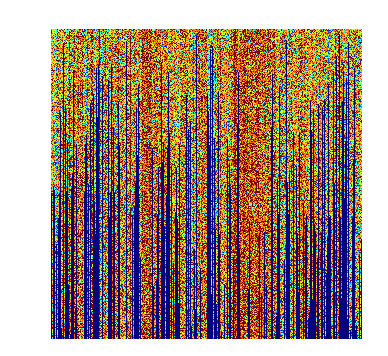

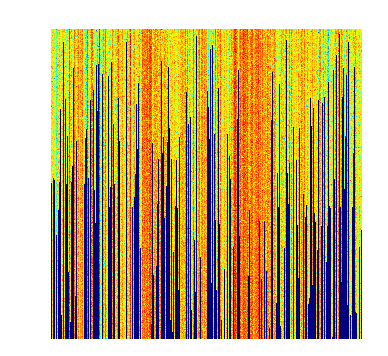

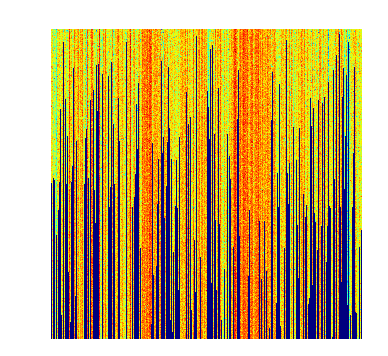

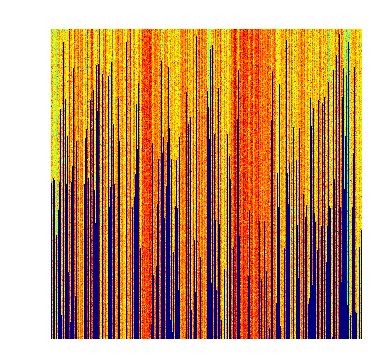

In [72]:
import matplotlib.pyplot as plt
% matplotlib inline

def statistics(sparse_matrix):
    rows, cols, ratings = sp.find(sparse_matrix)
    user_ratings = np.zeros(1000)
    item_ratings = np.zeros(10000)
    for i in range(10000):
        item_ratings[i] = np.count_nonzero(rows==i)
    for i in range(1000):
        user_ratings[i] = np.count_nonzero(cols==i)
    print('item min={},max={},mean={}'.format(np.min(item_ratings),np.max(item_ratings),np.mean(item_ratings)))
    print('user min={},max={},mean={}'.format(np.min(user_ratings),np.max(user_ratings),np.mean(user_ratings)))
    return item_ratings, user_ratings

def matrix_plot(dense_matrix, fname, cutoff=0):
    if cutoff > 0:
        ax = plt.matshow(dense_matrix[:cutoff,:])
    else:
        ax = plt.matshow(dense_matrix)
    plt.axis('off')
    plt.savefig(fname)

def create_sparse_matrix_plot(sparse_matrix, fname='',cutoff=1000):
    # TODO: doesn't work for axis=1 because of how axes are organized!
    ''' Create a dense matrix plot, squeezing all entries along specified axis.
    input:
        sparse_matrix    - scipy sparse matrix to visualize
        axis             - axis along which all nnz-elements will be squeezed.
    '''
    rows,cols,ratings = sp.find(sparse_matrix) 
    ratings_dense = np.zeros(sparse_matrix.shape)
    i_dense = 0
    i_total = []
    last_index = 0
    for i, rating in enumerate(ratings):
        index = cols[i]
        if index > last_index:
            i_total.append(i_dense)
            i_dense = 0
        ratings_dense[i_dense,index] = rating
        last_index = index
        i_dense += 1
    i_max=np.max(i_total)
    matrix_plot(ratings_dense, fname, min(i_max,cutoff))
    print('user min, max, mean:',np.min(i_total), np.max(i_total), np.mean(i_total))
    return i_total, ratings_dense[:i_max,:]



# Visualize matrices
its, uss = statistics(train_true)
i_total, ratings_dense = create_sparse_matrix_plot(train_true, '../results/Blending/matrix_train.png')

dense_matrices=[]
dense_matrices.append(ratings_dense.copy())
#j_total, _ = create_matrix_plot(train_true, axis=1)
for i,matrix_est in enumerate(train_est):
    its, uss = statistics(matrix_est)
    __, ratings_dense = create_sparse_matrix_plot(matrix_est, '../results/Blending/matrix_{}'.format(i+1))
    dense_matrices.append(ratings_dense.copy())

In [73]:
diff_matrix = dense_matrices[1]-dense_matrices[0]
print(np.max(diff_matrix))
matrix_plot(diff_matrix, '../results/matrix_diff0.png', 1000)

ValueError: operands could not be broadcast together with shapes (4373,1000) (4590,1000) 

In [78]:
def linear_blending(test_est, submissions_est, test_true):
    '''
    Do linear blending of different methods as described in:
    /http://www.commendo.at/UserFiles/commendo/File/Presentation_GrandPrize.pdf
    '''
    def create_matrix(matrix_list): 
        ''' 
        create P or Q matrix as described in 
        input:
        '''
        P_or_Q = np.empty((matrix_list[0].nnz, len(matrix_list)))
        for i,matrix in enumerate(matrix_list):
            __,__,ratings = sp.find(matrix)
            P_or_Q[:,i] = ratings
        return P_or_Q
        
    def get_predictions(P,Q,r):
        '''
        get predictions as best weighted combination of Q.
        '''
        x = np.linalg.solve(np.dot(P.T, P),np.dot(P.T,r))
        q_hat = np.dot(Q, x)
        return q_hat 
    
    P = create_matrix(test_est)
    Q = create_matrix(submission_est)
    __, __, r = sp.find(test_true)
    q_hat = get_predictions(P, Q, r)
    return q_hat


test_true = apply_indices([train_true], 'test')
q_hat = linear_blending(test_est, submission_est, test_true[0])
print(q_hat)

number of items: 10000, number of users: 1000
number of rows, cols: 29403 29403
number of non-zero elements in matrix 0: 29403


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all().

In [ ]:
validation_indices_file = '../data/blending_validation.csv'

In [53]:
rows_full.shape
test = np.hstack((rows_full, rows_full))
test.shape

(2353904,)